In [1]:
using LinearAlgebra, Test, SparseArrays, Plots, Parameters, OffsetArrays, DifferentialEquations, IterativeSolvers, LinearMaps
using Plots, BenchmarkTools

# Helper functions

In [2]:
using DiffEqOperators 
# solve model without matrix
function solve_transition_dynamics(O!, params, f_0, T; dt = 1.0)
    # unpack params
    @unpack θ, cohorts, ts_cohort, μ = params
    N = cohorts[1] # assume that N_t is invariant across all t
    

        
    # definte the corresponding ODE problem
    prob = ODEProblem(O!,f_0,(0.0,T), params)
    
    # solve the model
        solve(prob, LinearExponential(krylov=:simple), tstops=union(ts_cohort, T))
#     solve(prob, LinearExponential(krylov=:simple), tstops=union(0:dt:T, ts_cohort, T))
#     solve(prob, HochOst4(krylov=true), dt=0.1)
end

solve_transition_dynamics (generic function with 1 method)

In [3]:
# helper function for sum of cartesian indices
import Base.sum
function unit_vector(i::Int64, length::Int64)
   v = fill(0, length)
   v[i] = 1
   return CartesianIndex(Tuple(v))
end
sum(I::CartesianIndex) = sum(Tuple(I))
subtract_by_one(I::CartesianIndex, i::Int64, length::Int64) = I - unit_vector(i, length)
add_by_one(I::CartesianIndex, i::Int64, length::Int64) = I + unit_vector(i, length)

add_by_one (generic function with 1 method)

# Matrix-free multiplication operator

In [4]:
# method
function Q_a!(df, f, p, t)
    # unpack params
    @unpack θ, cohorts, ts_cohort, μ, full_aware_counts, any_aware_counts, i_pasts, i_futures = p
    N = cohorts[1] # assume that N_t is invariant across all t
    K = length(cohorts) # number of cohorts
    setsize = (N+1)^K;
    
    f = reshape(f, Tuple(fill(0:N, K)))
    df = reshape(df, Tuple(fill(0:N, K)))
    θ_t = θ(t)
    current_cohort = sum(t .> ts_cohort) + 1
    N_total = current_cohort*N;
    indices = CartesianIndices(f)
    
    for i_order in 1:setsize
        i = indices[i_order] # extract Cartesian index
        # (outflow)
        full_aware_ratio = full_aware_counts[i_order] / current_cohort # ratio of cohorts fully awared
        df[i] = -(((N_total - sum(i)) / N_total) * θ_t * (1-full_aware_ratio) + μ) * f[i]
        # (inflow)
        for cohort in 1:current_cohort
            # if the current status has some awareness in a cohort
            # then there's in-flow from past in the cohort
            if (i[cohort] > 0)  
                i_past = i_pasts[i_order, cohort]
                df[i] += ((N_total + 1 - sum(i)) / N_total) * (θ_t / current_cohort) * f[i_past]
            end
            # if the current status has no full-awareness in a cohort
            # then there's in-flow from more-awared status from the cohort source by forgetting
            if (i[cohort] < N) 
                # Inflow amount depends on the current status:
                # 1.1.2 can be from 2.1.2 and 1.2.2; 
                # note that the inflow from each case is μ/3
                # 1.1.1 can be from 2.1.1 and 1.2.1 and 1.1.2
                # note that the inflow from each case is μ/3 
                # 0.0.1 can be from 1.0.1 and 0.1.1 and 0.0.2
                # note that the inflow from case 1 is μ/2 while case 2/3 is μ
                # from source state forgetting is dispersed by any_aware_count_in_source_state
                # which is (any_aware_count + (i[cohort] == 0)) in the current state because 
                # if i[cohort] == 0 then the source state has any_aware_count + 1 (1 from cohort)
                # if i[cohort] != 0 then the source state has any_aware_count 
                # (since the source state has i[cohort] > 0)
                i_future = i_futures[i_order, cohort]
                df[i] += μ / (any_aware_counts[i_order] + (i[cohort] == 0)) * f[i_future]
            end
        end
    end
    df[1] += μ * f[1] # there is no forgetting in the state where no product is recognized
end

Q_a! (generic function with 1 method)

# With K cohorts

## Setup (Modify these lines for different setups)

In [5]:
K = 2
N = 20
Δt_cohort = 5
Δθ = 0.2

0.2

## Setup for the corresponding `params`

In [6]:
# getting some params
μ = 0.1 # forgetting rate
cohorts = tuple(fill(N, K)...)
ts_cohort = range(Δt_cohort, length = (K-1), step = Δt_cohort)
θs = range(Δθ, length = K, step = Δθ)
θ(t) = t < ts_cohort[1] ? θs[1] : θs[findall(t .>= ts_cohort)[end]] # return θ that corresponds to ts_cohort
T = ts_cohort[end] + Δt_cohort
params = (θ = θ, cohorts = cohorts, ts_cohort = ts_cohort, μ = μ)
f_0 = [1.0; fill(0.0, (N+1)^K-1)]
setsize = length(f_0)

# indices
indices = CartesianIndices(reshape(f_0, Tuple(fill(0:N, K))))
full_aware_counts = (i -> sum(Tuple(indices[i]) .== N)).(1:setsize) # number of cohorts that are fully awared
any_aware_counts = (i ->  sum(Tuple(indices[i]) .!= 0)).(1:setsize) # number of cohorts that aren't zero
i_pasts = [(indices[i] - unit_vector(j, length(indices[i]))) for i in 1:setsize, j in 1:K]
i_futures = [(indices[i] + unit_vector(j, length(indices[i]))) for i in 1:setsize, j in 1:K]
params = merge(params, (full_aware_counts = full_aware_counts, any_aware_counts = any_aware_counts,
                        i_pasts = i_pasts, i_futures = i_futures))

(θ = θ, cohorts = (20, 20), ts_cohort = 5:5:5, μ = 0.1, full_aware_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 2], any_aware_counts = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], i_pasts = CartesianIndex{2}[CartesianIndex(-1, 0) CartesianIndex(0, -1); CartesianIndex(0, 0) CartesianIndex(1, -1); … ; CartesianIndex(18, 20) CartesianIndex(19, 19); CartesianIndex(19, 20) CartesianIndex(20, 19)], i_futures = CartesianIndex{2}[CartesianIndex(1, 0) CartesianIndex(0, 1); CartesianIndex(2, 0) CartesianIndex(1, 1); … ; CartesianIndex(20, 20) CartesianIndex(19, 21); CartesianIndex(21, 20) CartesianIndex(20, 21)])

## Definte the corresponding operator and its properties

In [7]:
# solve the corresponding ODE
O! = MatrixFreeOperator(Q_a!, (params, 0.0))
Base.size(::typeof(O!), n) = n==1 || n == 2 ? setsize : 1
LinearAlgebra.opnorm(::typeof(O!), n::Real) = n==Inf ? 0.1 : nothing
LinearAlgebra.ishermitian(::typeof(O!)) = false


## Solve!

In [8]:
sol_awareness_matrix_free = solve_transition_dynamics(O!, params, f_0, T)
# enable the next line instead for benchmarking:
# sol_awareness_matrix_free = @btime solve_transition_dynamics($O!, $params, $f_0, $T) 

# convert to the counting solution
setsize = length(f_0)
indices = CartesianIndices(reshape(1:setsize, Tuple(fill(0:N, K))))
counts = (x -> sum(indices[x])).(1:setsize) # index to count size

f0_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 0]) # no product
f1_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 1]) # 1 product
f2_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 2]) # 2 products
f3_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 3]) # 3 products
f4_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 4]) # 4 products
f5_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 5]) # 5 products
f6_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 6]) # 6 products
f7_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 7]) # 7 products
f8_awareness_matrix_free(a) = sum(sol_awareness_matrix_free(a)[counts .== 8]) # 8 products

# plot
plot(0:0.01:T, [f0_awareness_matrix_free, f1_awareness_matrix_free, f2_awareness_matrix_free, 
        f3_awareness_matrix_free, f4_awareness_matrix_free, f5_awareness_matrix_free,
        f6_awareness_matrix_free, f7_awareness_matrix_free, f8_awareness_matrix_free],linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2" "f3" "f4" "f5" "f6" "f7" "f8"])

  5.942 ms (274118 allocations: 4.94 MiB)


## Find stationary distribution

  71.381 ms (3063302 allocations: 53.85 MiB)


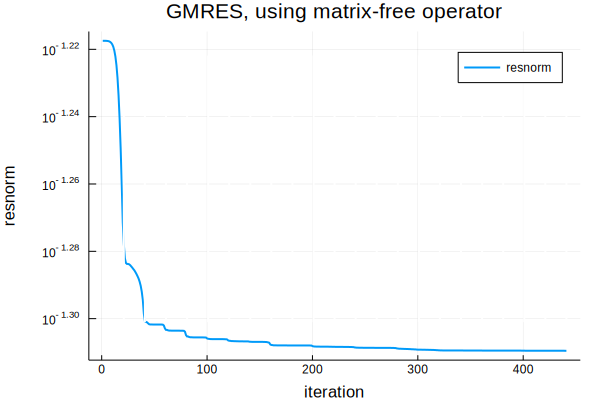

In [9]:
map_matfree! = LinearMap((y,x) -> Q_a!(y, x, params, T), length(f_0); ismutating=true)
stationary, history = @btime gmres!(fill(1/length(f_0), length(f_0)), map_matfree!, similar(f_0), log = true)
stationary /= norm(stationary) # normalize
plot(history, yscale = :log10,linewidth=2,
    title="GMRES, using matrix-free operator",
    xaxis="iteration",yaxis="resnorm")